In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("/Users/giovanni-lunetta/stat_4185/final_project/allstar_attempt/data/cleaned.csv")
df = df.drop("Unnamed: 0", axis=1)

In [2]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Select the variables to scale
X = df[['FG', 'FGA', '2P', '2PA', '3P', '3PA',
       'FTA', 'TRB', 'AST', 'STL', 'BLK', 'PTS', 'TS%', 'eFG%']]

# Create a StandardScaler object
scaler = StandardScaler()

# Apply the scaler to the selected variables
X_scaled = scaler.fit_transform(X)

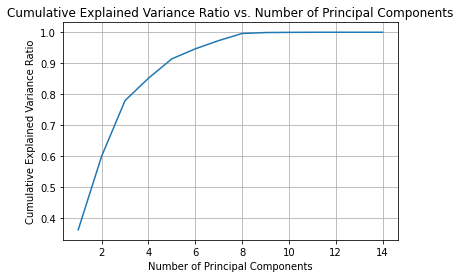

In [3]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA().fit(X_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualize the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid()
plt.show()

In [4]:
n_components = 3  # Choose the optimal number of components based on your analysis

# Create a PCA object with the optimal number of components
pca = PCA(n_components=n_components)

# Fit and transform the scaled data
X_pca = pca.fit_transform(X_scaled)

In [5]:
# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.3, random_state=42)

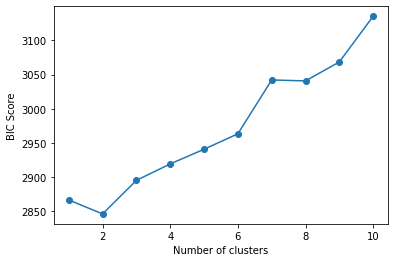

In [6]:
n_clusters = np.arange(1, 11)
bic_scores = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_pca)
    bic_scores.append(gmm.bic(X_train_pca))

plt.plot(n_clusters, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.show()

# Find the optimal number of clusters
optimal_n_clusters = n_clusters[np.argmin(bic_scores)]

In [7]:
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X_train_pca)
cluster_labels_train = gmm.predict(X_train_pca)

In [8]:
cluster_labels_test = gmm.predict(X_test_pca)

In [9]:
X_all_pca = np.vstack((X_train_pca, X_test_pca))
cluster_labels_all = np.concatenate((cluster_labels_train, cluster_labels_test))

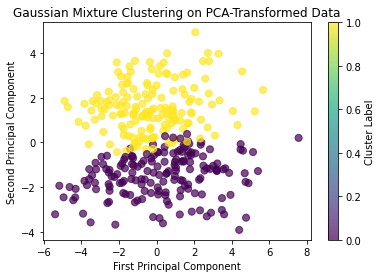

In [10]:
plt.scatter(X_all_pca[:, 0], X_all_pca[:, 1], c=cluster_labels_all, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Gaussian Mixture Clustering on PCA-Transformed Data')
plt.colorbar(label='Cluster Label')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silhouette Score
silhouette = silhouette_score(X_all_pca, cluster_labels_all)
print("Silhouette Score:", silhouette)

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_all_pca, cluster_labels_all)
print("Calinski-Harabasz Index:", calinski_harabasz)

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_all_pca, cluster_labels_all)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.22515609220033553
Calinski-Harabasz Index: 90.78490825802614
Davies-Bouldin Index: 1.6964855566944799


In [12]:
df['cluster'] = cluster_labels_all

In [13]:
# Use the same feature list as before
features = ['FG', 'FGA', '2P', '2PA', '3P', '3PA',
       'FTA', 'TRB', 'AST', 'STL', 'BLK', 'PTS', 'TS%', 'eFG%']

# features = ['ORtg', 'DRtg', 'PER', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
#        'USG%', 'Age', 'MP', '2P%', '3P%', 'FT%', 'TS%', 'eFG%', 'Pos']

mean_values = df.groupby('cluster')[features].mean()

In [14]:
from math import pi

def create_radar_chart(mean_values, features, clusters):
    # Set the number of variables and calculate the angle for each axis
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Set the radar chart figure
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Set the first axis on top and move clockwise
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines and labels
    plt.xticks(angles[:-1], features)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="gray", size=8)
    plt.ylim(0, 1)

    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the radar chart for each cluster
    for i in range(clusters):
        values = normalized_values.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Mean values by attribute for each cluster")
    plt.show()

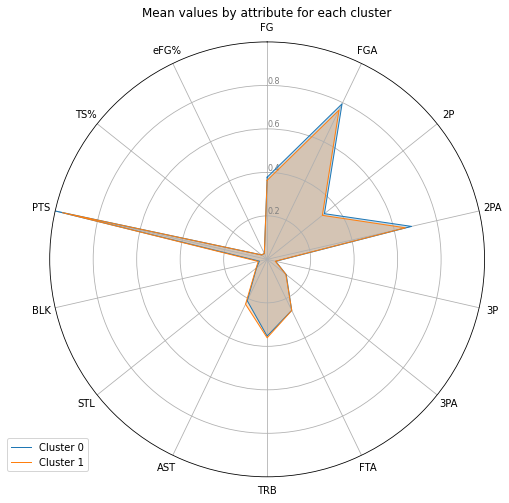

In [15]:
# Call the function to create the radar chart
create_radar_chart(mean_values, features, optimal_n_clusters)

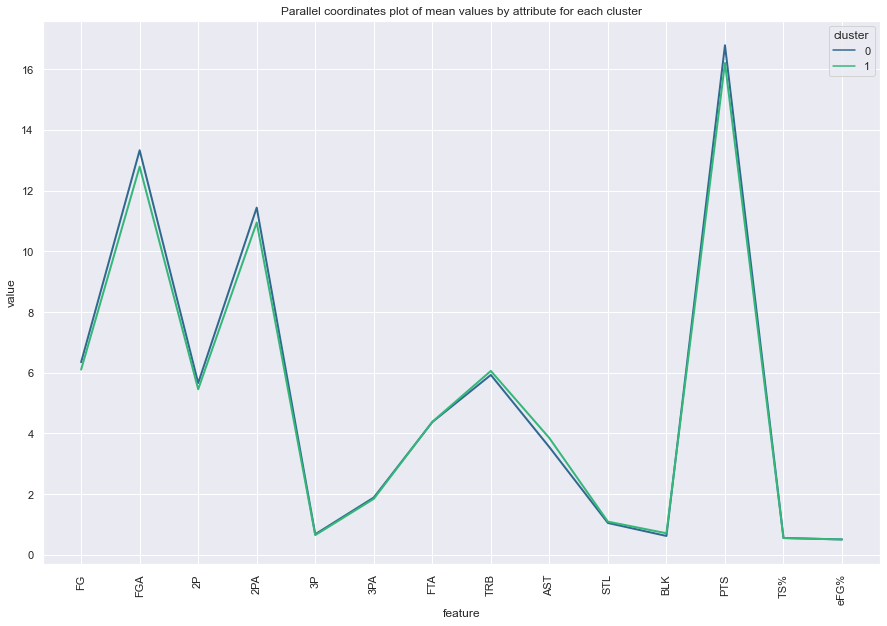

In [16]:
import seaborn as sns

def create_parallel_coordinates_plot(mean_values, features, clusters):
    # Create a new DataFrame with the cluster labels and mean values
    mean_values['cluster'] = mean_values.index
    mean_values = mean_values.reset_index(drop=True)

    # Plot the parallel coordinates plot
    plt.figure(figsize=(15, 10))
    sns.set(style="darkgrid")
    sns.lineplot(data=pd.melt(mean_values, 'cluster', var_name='feature', value_name='value'), x='feature', y='value', hue='cluster', palette='viridis', linewidth=2)
    plt.title("Parallel coordinates plot of mean values by attribute for each cluster")
    plt.xticks(rotation=90)
    plt.show()

# Call the function to create the parallel coordinates plot
create_parallel_coordinates_plot(mean_values, features, optimal_n_clusters)

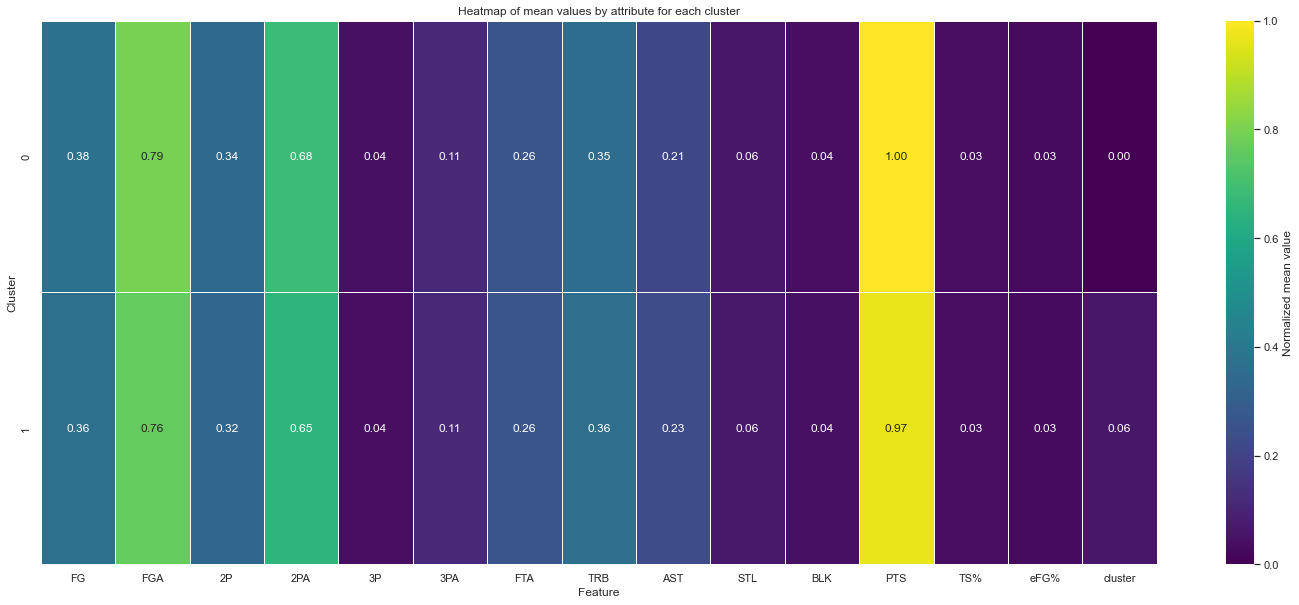

In [17]:
def create_heatmap(mean_values, features, clusters):
    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the heatmap
    plt.figure(figsize=(25, 10))
    sns.heatmap(normalized_values, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Normalized mean value'})
    plt.title("Heatmap of mean values by attribute for each cluster")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.show()

# Call the function to create the heatmap
create_heatmap(mean_values, features, optimal_n_clusters)